# Introduction

## Goals:
1. Classify main subject in an image
2. Localise on the subject by drawing bounding boxes around it. 

## Dataset
[MNIST](https://www.tensorflow.org/datasets/catalog/mnist) Dataset is being used. 
1. Images are of shape = (28, 28, 1) 
2. Since we want to localize on the image, we will be randomly placing it in a 75x75 grid box. 


Bounding Box localization is modelled as a regression problem. 

In [1]:
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import h5py

## WorkFlow: 

### Data Pipeline setup
1. Create a function to randomly place MNIST image in a 75x75 grid. 
2. get the bounding box values from the above process. 
3. Modify Dataset

### Training Strategy to be used

1. 1 GPU and 1 CPu on board machine. 
2. Mirrored Strategy to be used for training. 

### Model Architecture and Training. 
1. Loss Functions
2. Inference






## Utility Functions

### Visualization functions

In [160]:
LABELS = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]


In [194]:

from PIL import Image, ImageDraw

def plot_images_with_bbox(dataset, num_images, main_title, title_color):
    """
    dataset: dataset of type tf.data.dataset
    num_images: number of images to display in a row.
    main_title: Title of the figure
    title_color: color for the Title
    """
    for images, (labels, bbs) in dataset.take(1):
        fig, axis = plt.subplots(1, num_images, figsize=(16, 4))
        fig.suptitle(main_title, color=title_color)
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i+1)
            img = Image.fromarray(np.squeeze((images[i] * 255).numpy().astype(np.int8))).convert("RGB")
            x_min, y_min, x_max, y_max = bbs[i][0].numpy(), bbs[i][1].numpy(), bbs[i][2].numpy(), bbs[i][3].numpy()
            vert_1 = (x_min, y_min)
            vert_2 = (x_max, y_max)
            img = draw_bounding_box_on_image(img, (vert_1, vert_2))
            plt.imshow(img)
            plt.title(LABELS[np.argmax(labels[i])])
            plt.axis(False);
            pass
    pass

def draw_bounding_box_on_image(image, bounding_box):
    """
    Takes in an Image and its respective bounding box.
    PLots a red color bounding box around the image subject.
    returns the image.
    """
    bb_image = ImageDraw.Draw(image)
    bb_image.rectangle(bounding_box, outline=(255, 0, 0), width=1)
    return image

In [242]:
def plot_metrics(history):
    """
    Plot the training history (loss) of the network

    history: history.history dictionary from model.
    """
    classifier_loss = history['classifier_loss']
    bb_loss = history["bounding_box_regression_loss"]
    classifier_accuracy = history['classifier_accuracy']

    figure = plt.Figure(figsize=(10, 7))
    plt.plot(classifier_loss, c="orange", label="Classification Loss")
    plt.plot(classifier_accuracy, c="green", label="Classification Accuracy")
    plt.plot(bb_loss, c="red", label="regression loss")
    plt.legend()
    plt.title("Loss Curves for detection")
    plt.xlabel("EPOCHS")
    plt.show();

### Dataset Mapping Functions

In [42]:
def add_padding_and_bb(image, label):
    """
    Mapping function to add padding to the images, returning their bounding box co-ordinates and modified image.
    """
    final_h, final_w = 75, 75
    x_min, y_min = tf.random.uniform(shape=(), minval=0, maxval=48, dtype=tf.int32), tf.random.uniform(shape=(), minval=0, maxval=48, dtype=tf.int32)
    x_max, y_max = x_min + 28, y_min + 28
    image = tf.image.pad_to_bounding_box(image=image, offset_height=y_min, offset_width=x_min, target_height=final_h, target_width=final_w)
    image = tf.cast(image, tf.float16)/255.0
    return image, (tf.one_hot(label, 10), [x_min, y_min, x_max, y_max])


## Strategy

Using default strategy which uses CPU and single GPU

In [31]:
gpus = tf.config.list_logical_devices("GPU")

if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print("Running on multiple GPUS ", [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print("Running on single GPU, ", gpus[0].name)
else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

print("Number of accelerators : ", strategy.num_replicas_in_sync)

Running on single GPU,  /device:GPU:0
Number of accelerators :  1


## DataPipeline Setup

In [186]:
# Setting Global Batch Size
# Trickles down accordingly to each replica
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

In [187]:
# Getting the training and test dataset

with strategy.scope():
    train_ds, train_info = tfds.load("mnist",split="train",as_supervised=True, with_info= True)
    # train_ds, test_ds = ds["train"], ds["test"]
    test_ds, test_info = tfds.load("mnist", split="test", as_supervised=True, with_info=True)
    train_ds = train_ds.map(add_padding_and_bb, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(add_padding_and_bb, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Visualizing the Datasets

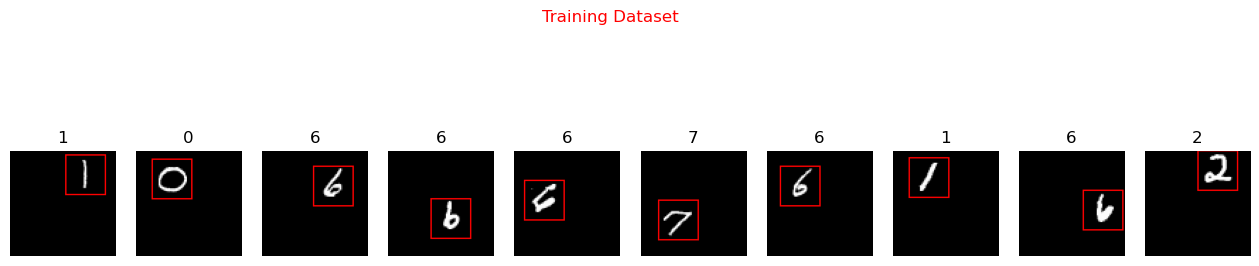

In [195]:
plot_images_with_bbox(train_ds, 10, "Training Dataset", "red")

## Defining the network architecture

We will be working with a custom CNN architecture.

A typical object detection algorithm has the following elements:

* `feature_extractor` : This section of the algorithm contains convolution layers that focus on extracting the features from the image ( feature vector generation)

* `classifier` : Output layers for classification which contain Dense layers and a classification layer with softmax.

* `bounding_box_regression`: Predicts 4 values which define the co-ordinates of the bounding box (xmin, ymin, xmax, ymax)


The Final model combines the layers for feature extraction, classification and bounding box prediction.


In [228]:
"""
feature extraction layer made of alternating convolutional and pooling blocks
"""
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(filters=16, activation="relu", kernel_size=3, input_shape=(75, 75, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(32, kernel_size = 3, activation="relu")(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    return x

"""
The Dense layer has a flatten layer above it. 
Follows the feature extraction layers
"""
def dense_layers(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    return x

"""
Consists of a dense classification layer with softmax activation
"""
def classifier(inputs):
    x = tf.keras.layers.Dense(10, activation="softmax", name="classifier")(inputs)
    return x

def bounding_box_regression(inputs):
    x = tf.keras.layers.Dense(units=4, name="bounding_box_regression")(inputs)
    return x

def final_model(inputs):
    feature_vec= feature_extractor(inputs)
    dense_output = dense_layers(feature_vec)

    """
    The above output of the dense layers is to be split
    amongst the classification and bounding box regression branches
    """
    classification_output = classifier(dense_output)
    bounding_box_regression_output = bounding_box_regression(dense_output)

    model = tf.keras.Model(inputs=input, outputs=[classification_output, bounding_box_regression_output])

    return model

def build_and_compile_model(inputs):
    model = final_model(inputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss={
            "classifier": "categorical_crossentropy",
            "bounding_box_regression": "mse"
        },
        metrics={
            "classifier": "accuracy",
            "bounding_box_regression": "mse"
        }
    )
    return model

In [229]:
with strategy.scope():
    input = tf.keras.layers.Input(shape=(75, 75, 1))
    model = build_and_compile_model(input)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 73, 73, 16)   160         ['input_8[0][0]']                
                                                                                                  
 average_pooling2d_16 (AverageP  (None, 36, 36, 16)  0           ['conv2d_16[0][0]']              
 ooling2D)                                                                                        
                                                                                                  
 conv2d_17 (Conv2D)             (None, 34, 34, 32)   4640        ['average_pooling2d_16[0][0

In [230]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    urls=['https://storage.googleapis.com/cvdf-datasets/mnist/'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [231]:
EPOCHS = 10
steps_per_epoch = 60000//BATCH_SIZE 

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 25.4605 - classifier_loss: 2.4310 - bounding_box_regression_loss: 23.0295 - classifier_accuracy: 0.1427 - bounding_box_regression_mse: 23.0295
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 3.3954 - classifier_loss: 2.1197 - bounding_box_regression_loss: 1.2756 - classifier_accuracy: 0.2360 - bounding_box_regression_mse: 1.2756
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 2.6557 - classifier_loss: 1.9729 - bounding_box_regression_loss: 0.6828 - classifier_accuracy: 0.2842 - bounding_box_regression_mse: 0.6828
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 2.1822 - classifier_loss: 1.6245 - bounding_box_regression_loss: 0.5576 - classifier_accuracy: 0.4163 - bounding_box_regression_mse: 0.5576
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 1.3702 - classifier_loss: 0.8891 - bounding_box_regr

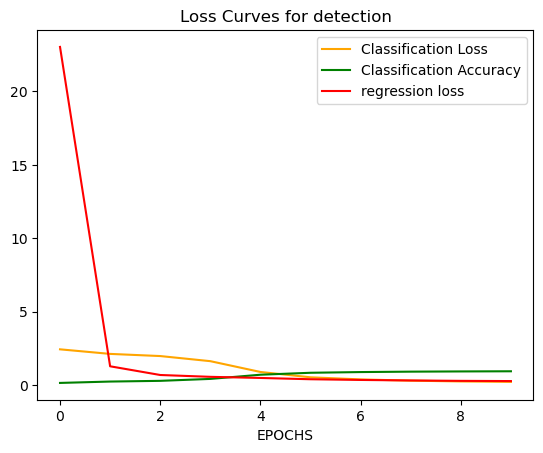

In [243]:
plot_metrics(history.history)

## Intersection over union

In [244]:
def intersection_over_union(pred_bb, true_bb):
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = np.split(pred_bb, 4, axis=1)
    x_min_true, y_min_true, x_max_true, y_max_true = np.split(true_bb, 4, axis=1)
    smoothing_factor=  1e-10

    x_min_overlap = np.maximum(x_min_pred, x_min_true)
    x_max_overlap = np.maximum(x_max_pred, x_max_true)
    y_max_overlap = np.maximum(y_max_pred, y_max_true)
    y_min_overlap = np.maximum(y_min_pred, y_min_true)

    pred_box_area = (x_max_pred - x_min_pred) * (y_max_pred - y_min_pred)
    true_box_area = (x_max_true - x_min_true) * (y_max_true - y_min_true)

    overlap_area = np.maximum((x_max_overlap - x_min_overlap), 0) * np.maximum((y_max_overlap - y_min_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou